# imports

In [1]:
import datetime
import math
import os
import random
import time

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.optimize import OptimizeResult, brute, minimize, minimize_scalar
from tqdm.notebook import tqdm
from decouple import AutoConfig
from pathlib import Path
from math import ceil
import ray

from src.utils.profiles import generate_dep_Pax_Counters, show_up_function
from src.utils.profiles_from_schedule import (
    generate_dep_Pax_Counters as custom_generate_dep_Pax_Counters,
)

from src.simfunc.KIX_T1d import KIX_T1d, univariate_cost_function_generator_T1d_N
from src.simfunc.KIX_T1d_CUSBD import (
    KIX_T1d_CUSBD,
    univariate_cost_function_generator_T1d_CUSBD_N,
)

from src.simfunc.KIX_T1d_CUSBD import (
    cost_function_T1d_CUSBD_2var_modern_pax_ratio_CUSBD_opening_duration as cost_2_var,
)

from src.utils.optimizers import (
    custcallback,
    custmin,
    custmin_multicore,
    custcallback_multicore,
)
from src.utils.helpers import (
    calculate_EBS_LBC,
    calculate_avg_dwell_time,
    calculate_EBS_modern_pax_only,
)

/home/antoine/miniconda3/envs/KAPpaxsim2/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  warnings.warn(


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

%load_ext nb_black

In [ ]:
ray.shutdown()
ray.init()

## parameters import

In [2]:
# get the paths to config
root_path = Path(os.getcwd()) / "../../"
DOTENV_FILE_PATH = root_path / "data/secret/.env"
config = AutoConfig(search_path=DOTENV_FILE_PATH)
path_param = root_path / config("ADRM_param_full_path")

In [3]:
df_param_onedrive = pd.read_excel(
    path_param,
    sheet_name="Dynamic",
)

# generate df_set_param_T1d_from_drive from one drive excel file (assumptions all dept)
df_param_input = df_param_onedrive.set_index("item", drop=True, inplace=False)

# keep only T1 Int'l dep results
mask_T1d = (df_param_input["terminal"] == "T1") & (df_param_input["Direction"] == "D")
df_param_input_T1 = df_param_input[mask_T1d]

df_param_input_T1 = df_param_input_T1.drop(
    columns=["unit", "terminal", "type", "remarks", "Direction"]
)

# take values from assumption files and put them in a dictionnary
list_item = [
    "target_peak_STD",
    "Pt_checkin_1step_counter",
    "Pt_checkin_2step_counter",
    "N_kiosk",
    "Pt_kiosk",
    "N_security_lanes",
    "Pt_security_lanes",
    "N_emigration_counter",
    "Pt_emigration_counter",
    "N_emigration_self",
    "Pt_emigration_self",
    "modern_pax_ratio",
    "digital_pax_ratio",
    "premium_pax_ratio",
    "start_special_pax_ratio",
    "end_special_pax_ratio",
]

dct_set_param_T1d_from_drive = {
    item: list(df_param_input_T1.loc[item, :]) for item in list_item
}
len_dct_set_param_T1d_from_drive = len(dct_set_param_T1d_from_drive["target_peak_STD"])
dct_set_param_T1d_from_drive["target_peak"] = dct_set_param_T1d_from_drive.pop(
    "target_peak_STD"
)

# define values that are not in assumption files
dct_set_param_T1d_from_drive["freq"] = [
    "1min" for i in range(len_dct_set_param_T1d_from_drive)
]
dct_set_param_T1d_from_drive["win"] = [
    15 for i in range(len_dct_set_param_T1d_from_drive)
]
dct_set_param_T1d_from_drive["show_loading"] = [
    False for i in range(len_dct_set_param_T1d_from_drive)
]
dct_set_param_T1d_from_drive["show_graph"] = [
    False for i in range(len_dct_set_param_T1d_from_drive)
]
dct_set_param_T1d_from_drive["save_graph"] = [
    False for i in range(len_dct_set_param_T1d_from_drive)
]
dct_set_param_T1d_from_drive["save_xls"] = [
    False for i in range(len_dct_set_param_T1d_from_drive)
]

# change the start & end special pax, it was a bad idea
dct_set_param_T1d_from_drive["start_special_pax_ratio"] = [
    0 for i in range(len_dct_set_param_T1d_from_drive)
]

dct_set_param_T1d_from_drive["end_special_pax_ratio"] = [
    1 for i in range(len_dct_set_param_T1d_from_drive)
]

df_set_param_T1d_from_drive = pd.DataFrame.from_dict(dct_set_param_T1d_from_drive)

df_set_param_T1d = df_set_param_T1d_from_drive.copy()
dct_set_param_T1d = dct_set_param_T1d_from_drive.copy()

# create the dictionary of param for the run from the dct_set_param
# we take the values for 2025
dct_run_param = {keys: value[5] for keys, value in dct_set_param_T1d.items()}

## cost and grid_search def

In [4]:
def cost_generator(x, EBS_number, dct_run_param_T1d_2025):
    cost = cost_2_var(
        x=x,  # ['CUSBD_opening_duration' in minutes,'modern_pax_ratio']
        EBS_capacity=EBS_number,  # cost target
        target_wait_time=5,  # target waiting time in minutes
        dct_param_T1d=dct_run_param_T1d_2025,  # includes df_Pax
        target_peak=3880,  # to select good schedule when generating df_Counters
        custom_counter_rule=False,  # to generate df_Counters
        call_n_iter=None,
        totalpbar=None,
    )
    return cost


def grid_search(
    cost_generator,
    EBS_number,
    dct_run_param_T1d_2025,
    xmin=150,
    xmax=360,
    N_fev_x=7,
    ymin=0.05,
    ymax=0.99,
    N_fev_y=6,
    N_grid_search=2,
):
    # parameter ray for parallel computing
    @ray.remote
    def f(x, EBS_number=EBS_number):
        return cost_generator(
            x, EBS_number=EBS_number, dct_run_param_T1d_2025=dct_run_param_T1d_2025
        )

    # create dct of results
    dct_grid_search = {}

    for n in range(N_grid_search):
        # build grid_list
        x_range = list(np.linspace(xmin, xmax, N_fev_x))
        y_range = list(np.linspace(ymin, ymax, N_fev_y))
        grid_list = [(x, y) for y in y_range for x in x_range]

        # evaluate all points of the grid in parallel
        futures = [f.remote(i) for i in grid_list]
        results = ray.get(futures)

        # get the best point
        bestz = min(results)
        index = results.index(bestz)
        best_point = grid_list[index]
        bestx = best_point[0]
        besty = best_point[1]

        # build new ranges for next iteration's grid_list
        # new range on x
        if bestx != xmin:
            xmin = x_range[x_range.index(bestx) - 1]
        if bestx != xmax:
            xmax = x_range[x_range.index(bestx) + 1]

        # new range on y
        if besty != ymin:
            ymin = y_range[y_range.index(besty) - 1]
        if besty != ymax:
            ymax = y_range[y_range.index(besty) + 1]

        # store grid search results
        dct_grid_search[n] = [grid_list, results]

    return bestx, besty, bestz, dct_grid_search

### successive grid optimization

In [5]:
# calculate df_Pax
df_Pax_2025, _ = generate_dep_Pax_Counters(
    target_peak=3880,  # for quick test, real FY2025 value is 3880
    terminal="T1",
    custom_counter_rule=False,  # current allocation rule
)

# initialize dct_run_param
dct_run_param_T1d_2025 = dct_run_param.copy()

dct_run_param_T1d_2025["df_Pax"] = df_Pax_2025
dct_run_param_T1d_2025["N_kiosk"] = 99999  # we initialize with a lot of kiosk
dct_run_param_T1d_2025["digital_pax_ratio"] = 0  # we keep only modern pax
dct_run_param_T1d_2025["N_CUSBD"] = 24
dct_run_param_T1d_2025.pop("target_peak")
dct_run_param_T1d_2025["path"] = None

Pax and counter generation...: 100%|██████████████████████████████████████████████████████| 2/2 [00:19<00:00,  9.53s/it]


In [ ]:
# define ranges of parameters
CUSBD_number_range = [24, 48, 72]
EBS_number_range = [800, 1900]

# create df_result_opti
column_CUSBD_number = [a for a in CUSBD_number_range for b in EBS_number_range]
column_EBS_number = [a for b in CUSBD_number_range for a in EBS_number_range]
columns_list = [
    "CUSBD_number",
    "EBS_number",
    "N_Counter",
    "N_kiosk",
    "CUSBD_opening_duration",
    "modern_pax_ratio",
    "waiting_time_counters",
    "total_dep_process_time",
    "dwell_time",
]

df_result_opti = pd.DataFrame(columns=columns_list)
df_result_opti["CUSBD_number"] = column_CUSBD_number
df_result_opti["EBS_number"] = column_EBS_number

In [ ]:
for CUSBD_number in CUSBD_number_range:
    for EBS_number in EBS_number_range:
        # initialize dct_param_opti
        dct_param_opti = dct_run_param_T1d_2025.copy()
        dct_param_opti["N_CUSBD"] = CUSBD_number
        dct_param_opti["N_kiosk"] = 99999  # we initialize with a lot of kiosk

        # optimize 'CUSBD_opening_duration' & 'modern_pax_ratio'
        (bestx, besty, bestz, dct_grid_search) = grid_search(
            cost_generator,
            EBS_number=EBS_number,
            dct_run_param_T1d_2025=dct_param_opti,
            xmin=150,
            xmax=360,
            N_fev_x=7,
            ymin=0.05,
            ymax=0.99,
            N_fev_y=6,
            N_grid_search=2,
        )

        dct_param_opti["CUSBD_opening_duration"] = bestx
        dct_param_opti["modern_pax_ratio"] = besty

        # optimize N_kiosk
        # allocation rule depending on modern_pax_ratio
        kwargs_rule = {
            "start_time": 3.5,
            "onecounter_time": 0.75,
            "base_n_counter": ceil(3 * (1 - besty)),
            "seats_per_add_counter": ceil(110 / (1 - besty)),
        }
        # generate df_Counter (only)
        df_Counters = show_up_function(
            target_peak=3880,
            direction="D",
            system="check-in",
            ratio=1,
            terminal="T1",
            CTG_type="A",
            custom_showup=False,
            custom_counter_rule=True,
            **kwargs_rule,
        )

        dct_param_opti["df_Counters"] = df_Counters

        # kwargs for the optimization of N_kiosk
        kwargs = {
            "dct_param_T1d": dct_param_opti,
            "variable_string": "N_kiosk",  # eg. N_Z, N_kiosk, N_CUSBD
            "target_wait_time": 1.5,  # target waiting time in minutes
            "call_n_iter": None,
            "totalpbar": None,
        }

        # options for custom optimizer
        options = {
            "guess": int(32),
            "N_core": 47,
            "callback": custcallback_multicore,
            "tol": 1,
        }

        # run the optimization for that variable
        print("optimization for kiosk")
        f = univariate_cost_function_generator_T1d_CUSBD_N(**kwargs)
        (
            bestx_kiosk,
            besty_kiosk,
            finished_kiosk,
            all_x_kiosk,
            all_y_kiosk,
        ) = custmin_multicore(f, **options)

        dct_param_opti["N_kiosk"] = bestx_kiosk

        # calculate wait time, total_dep_time and dwell_time

        (
            df_result,
            list_KPI_run,
            dct_hist_wait_time,
            dct_hist_queue_length,
        ) = KIX_T1d_CUSBD(**dct_param_opti)

        df_dwell, mean, top90 = calculate_avg_dwell_time(
            df_result,
            offset=pd.Timedelta(minutes=60),
        )

        # write results in dataframe

        mask = (df_result_opti["CUSBD_number"] == CUSBD_number) & (
            df_result_opti["EBS_number"] == EBS_number
        )

        df_result_opti.loc[mask, "waiting_time_counters"] = dct_hist_wait_time[
            "checkin_counter"
        ].quantile(q=0.9)
        df_result_opti.loc[mask, "dwell_time"] = mean

        df_result_opti.loc[mask, "CUSBD_opening_duration"] = bestx
        df_result_opti.loc[mask, "modern_pax_ratio"] = besty
        df_result_opti.loc[mask, "N_Counter"] = df_Counters["total"].max()
        df_result_opti.loc[mask, "N_kiosk"] = bestx_kiosk

In [ ]:
path_report = root_path / "reports/202107_EBS_CUSBD_capacity_v4_start_1040pm.xlsx"

writer = pd.ExcelWriter(
    path_report,
    engine="xlsxwriter",
)
df_result_opti.to_excel(writer, sheet_name="results")
writer.save()

In [ ]:
df_result_opti

# result tests

In [7]:
dct_param_opti = dct_run_param_T1d_2025.copy()
dct_param_opti["CUSBD_opening_duration"] = 196.666
dct_param_opti["modern_pax_ratio"] = 0.3884
dct_param_opti["N_CUSBD"] = 24
dct_param_opti["N_kiosk"] = 25
dct_param_opti["show_graph"] = True
dct_param_opti["show_loading"] = True

In [8]:
# optimize N_kiosk
# allocation rule depending on modern_pax_ratio
kwargs_rule = {
    "start_time": 3.5,
    "onecounter_time": 0.75,
    "base_n_counter": ceil(3 * (1 - dct_param_opti["modern_pax_ratio"])),
    "seats_per_add_counter": ceil(110 / (1 - dct_param_opti["modern_pax_ratio"])),
}
# generate df_Counter (only)
df_Counters = show_up_function(
    target_peak=3880,
    direction="D",
    system="check-in",
    ratio=1,
    terminal="T1",
    CTG_type="A",
    custom_showup=False,
    custom_counter_rule=True,
    **kwargs_rule,
)

dct_param_opti["df_Counters"] = df_Counters

   path  Pt_checkin_1step_counter  Pt_checkin_2step_counter  N_kiosk  \
0  None                  1.603333                      1.27       25   

   Pt_kiosk  N_CUSBD  CUSBD_opening_duration  N_security_lanes  \
0       1.5       24                 196.666              22.0   

   Pt_security_lanes  N_emigration_counter  ...  premium_pax_ratio  \
0           0.233333                  26.0  ...               0.05   

   start_special_pax_ratio  end_special_pax_ratio  freq  win  show_loading  \
0                        0                      1  1min   15         False   

   show_graph  save_graph save_xls  call_n_iter  
0        True       False    False         None  

[1 rows x 25 columns]


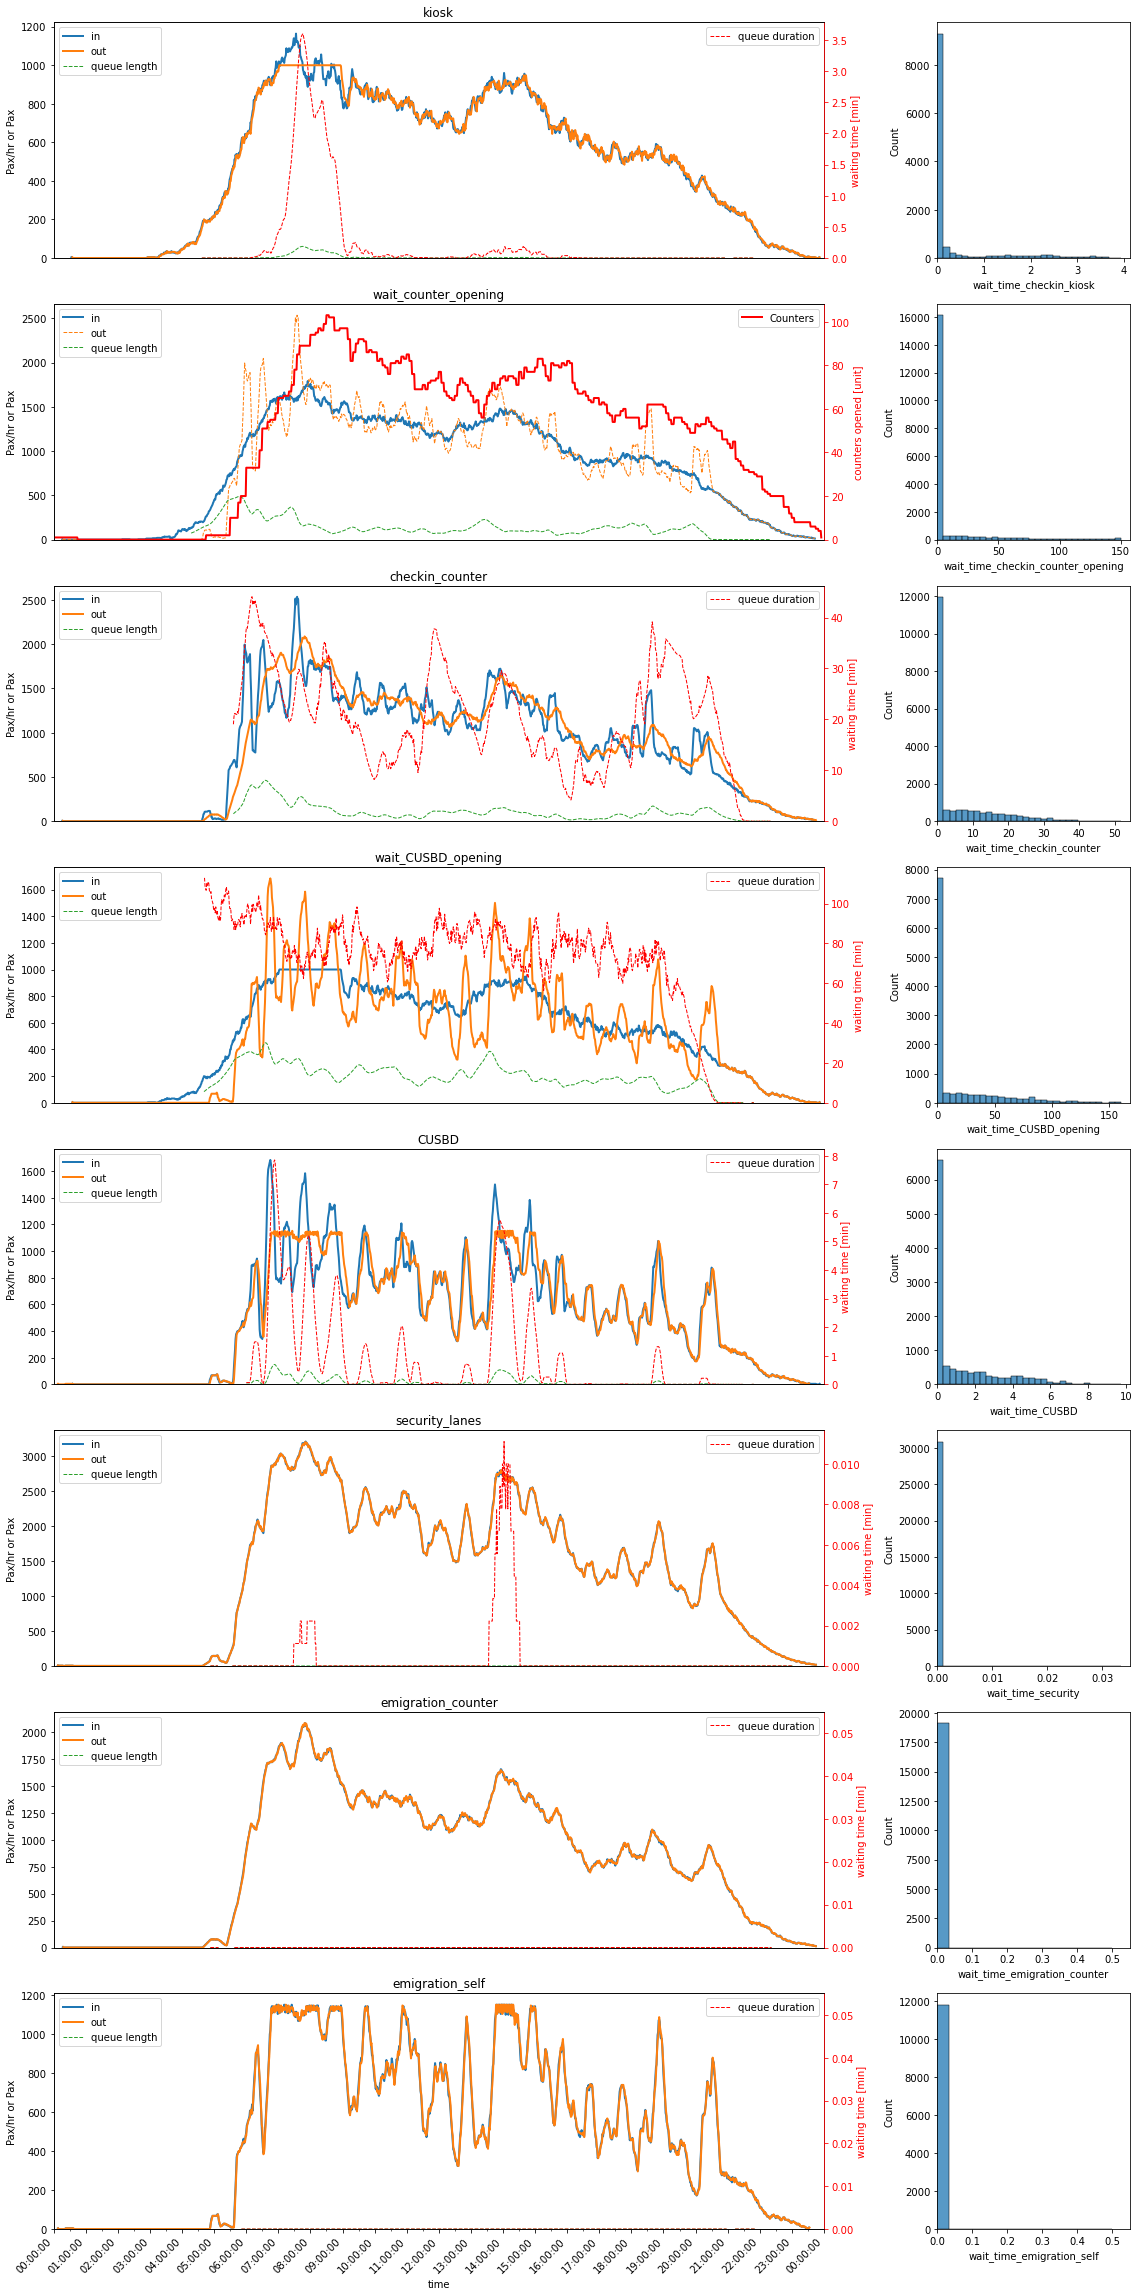

In [9]:
(
    df_result,
    list_KPI_run,
    dct_hist_wait_time,
    dct_hist_queue_length,
) = KIX_T1d_CUSBD(**dct_param_opti)

In [11]:
MUP_open_time = pd.Timedelta(hours=2, minutes=10)
MUP_close_time = pd.Timedelta(hours=1)


# change the times after midnight to the next day to calculate properly
end = pd.Timestamp("2020-10-13 02:00:00")
mask_late_flight = df_result["STD"] < end
df_result.loc[mask_late_flight, "STD"] += pd.Timedelta(days=1)

# mask for bags who will use EBS
# we take start security queue because some come from checkin and some from CUSBD
# we should also remove no bag pax (TBD)

mask_EBS = df_result["start_security_queue"] < df_result["STD"] - MUP_open_time
df_result.loc[mask_EBS, "EBS_in"] = df_result.loc[mask_EBS, "start_security_queue"]
df_result.loc[mask_EBS, "EBS_out"] = df_result.loc[mask_EBS, "STD"] - MUP_open_time

plt_in_EBS = (
    df_result.loc[mask_EBS, ["EBS_in", "Pax_N"]]
    .set_index("EBS_in", drop=False)["Pax_N"]
    .resample("15min")
    .agg(["sum"])
    .cumsum()
)

plt_out_EBS = (
    df_result.loc[mask_EBS, ["EBS_out", "Pax_N"]]
    .set_index("EBS_out", drop=False)["Pax_N"]
    .resample("15min")
    .agg(["sum"])
    .cumsum()
)

EBS_req = plt_in_EBS - plt_out_EBS

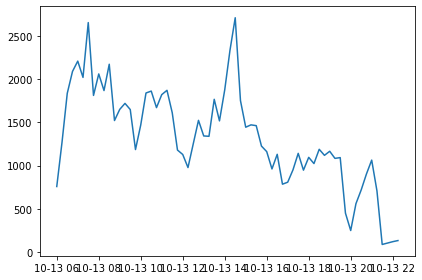

In [13]:
plt.plot(EBS_req)